In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import missingno as msno
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score,roc_auc_score,roc_curve,auc,precision_score


sns.set(style="whitegrid")
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('punkt')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_csv("/kaggle/input/threads-an-instagram-app-reviews/threads_reviews.csv")
df.head()

,source,review_description,rating,review_date
0,Google Play,Meh. Not the greatest experience on a Chromebo...,2,2023-07-08 14:18:24
1,Google Play,Pretty good for a first launch!! Its easy to u...,3,2023-07-19 20:52:48
2,Google Play,"For a brand new app, it's very well optimized....",3,2023-07-06 23:03:11
3,Google Play,"Great app with a lot of potential! However, th...",3,2023-07-10 00:53:25
4,Google Play,"The app is good, but it needs a lot of functio...",3,2023-07-06 16:57:43


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32910 entries, 0 to 32909
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   source              32910 non-null  object
 1   review_description  32910 non-null  object
 2   rating              32910 non-null  int64 
 3   review_date         32910 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


In [4]:
df.describe()

,rating
count,32910.000000
mean,3.398481
std,1.751480
min,1.000000
25%,1.000000
50%,4.000000
75%,5.000000
max,5.000000


In [5]:
df.duplicated().sum()

1

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.isnull().sum()

source                0
review_description    0
rating                0
review_date           0
dtype: int64

In [8]:
df["review_date"] = pd.to_datetime(df["review_date"])

In [9]:
df.rename(columns={'review_date': 'date',
                  "review_description" : "desc"}, inplace=True)

In [10]:
df.head()

,source,desc,rating,date
0,Google Play,Meh. Not the greatest experience on a Chromebo...,2,2023-07-08 14:18:24
1,Google Play,Pretty good for a first launch!! Its easy to u...,3,2023-07-19 20:52:48
2,Google Play,"For a brand new app, it's very well optimized....",3,2023-07-06 23:03:11
3,Google Play,"Great app with a lot of potential! However, th...",3,2023-07-10 00:53:25
4,Google Play,"The app is good, but it needs a lot of functio...",3,2023-07-06 16:57:43


In [11]:
df["day_name"] = df["date"].dt.day_name()

In [12]:
df["weekend"] = np.where(df["day_name"].isin (["Sunday","Saturday"]),1,0)

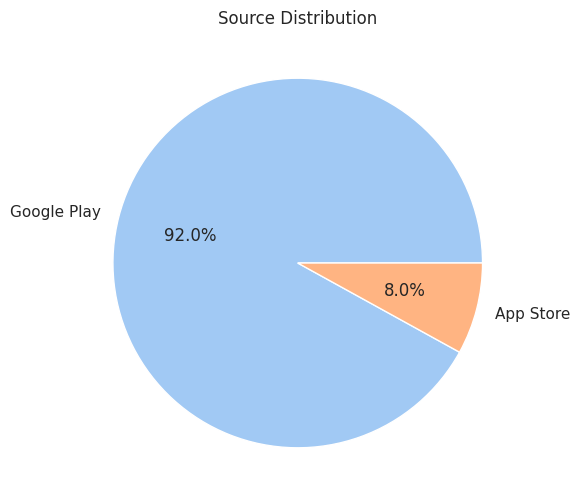

In [13]:
source_counts = df['source'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(source_counts, labels=source_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Source Distribution')
plt.show()

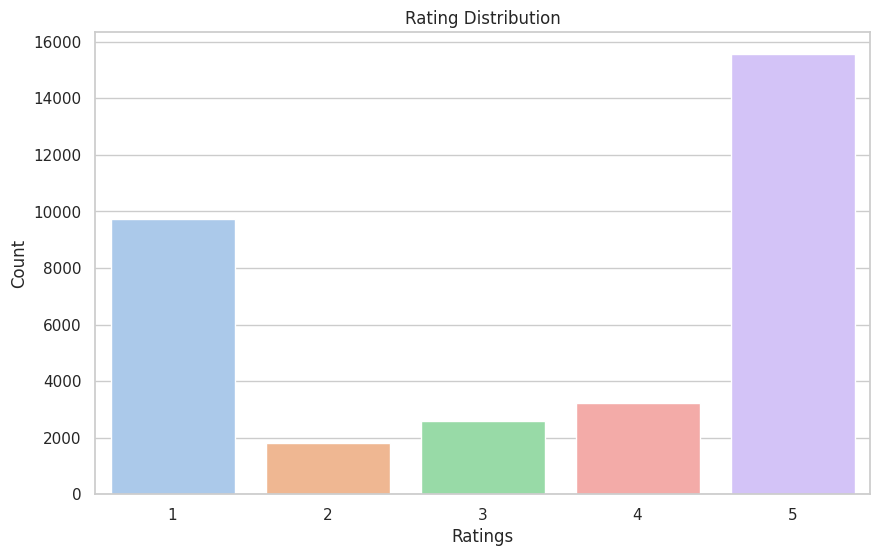

In [14]:
plt.figure(figsize=(10,6))

sns.countplot(x='rating', data=df, palette='pastel')
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.title("Rating Distribution")
plt.show()

<Axes: xlabel='day_name', ylabel='rating'>

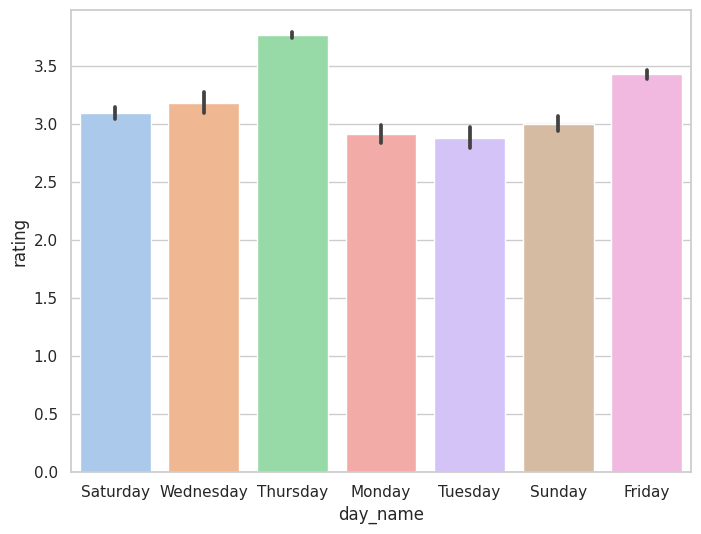

In [15]:
plt.figure(figsize=(8,6))

sns.barplot(x=df["day_name"],y=df["rating"],palette='pastel')

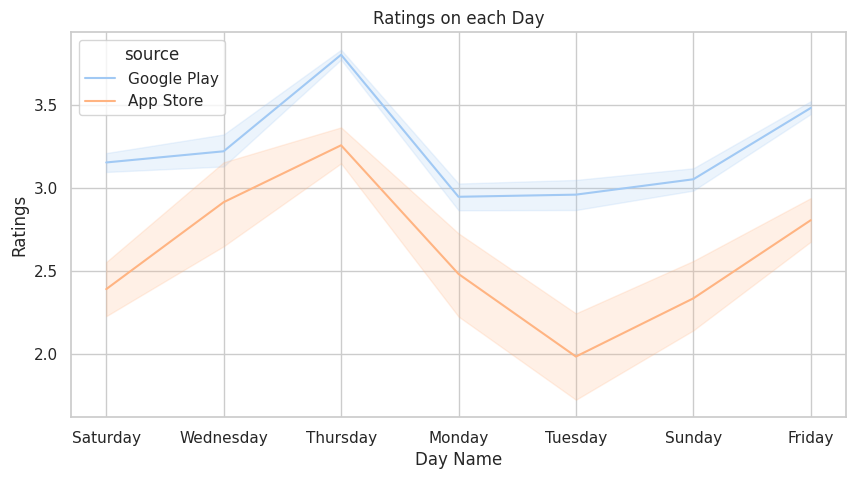

In [16]:
plt.figure(figsize=(10,5))
sns.lineplot(x=df["day_name"],y=df["rating"],hue=df["source"],palette='pastel')
plt.xlabel("Day Name")
plt.ylabel("Ratings")
plt.title("Ratings on each Day")
# plt.xticks(rotation=45)
plt.show()

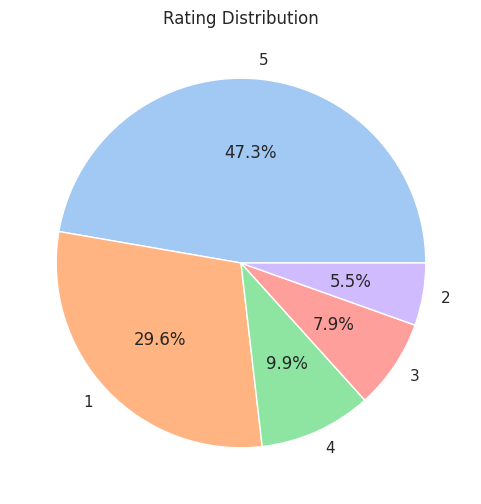

In [17]:
rate = df["rating"].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(rate, labels=rate.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Rating Distribution')
plt.show()

<Axes: >

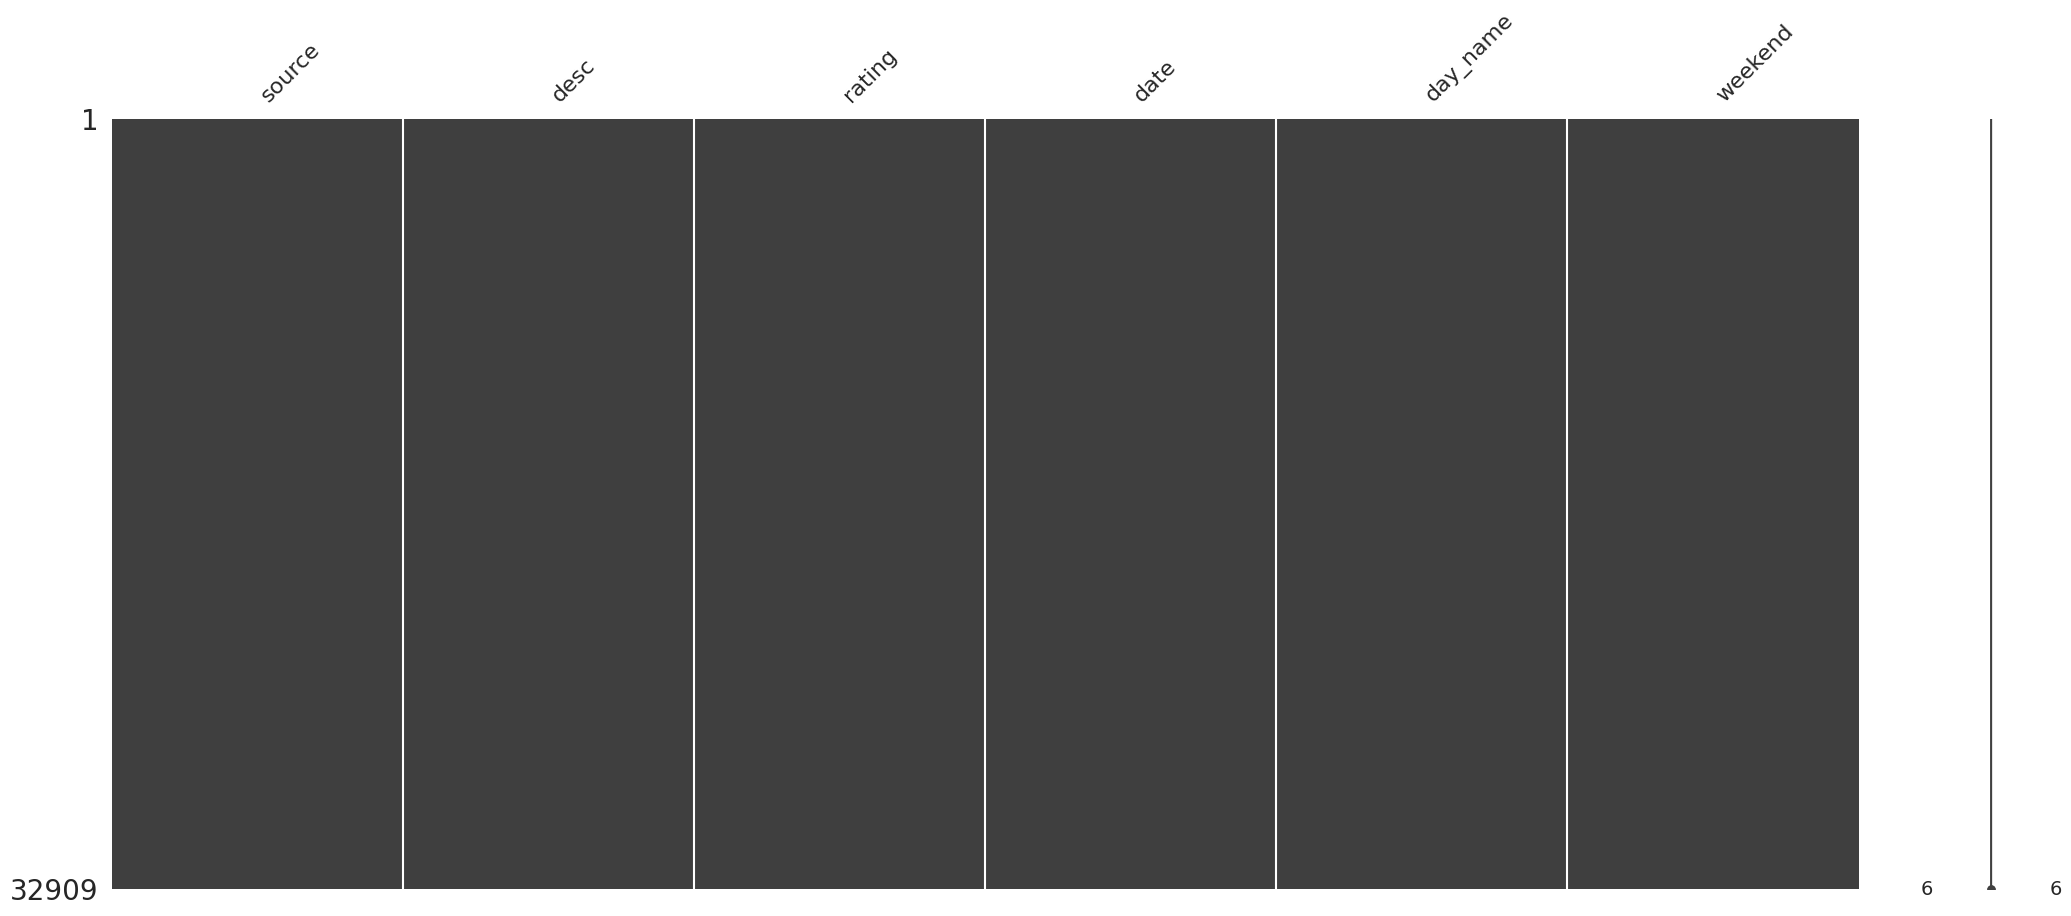

In [18]:
msno.matrix(df)

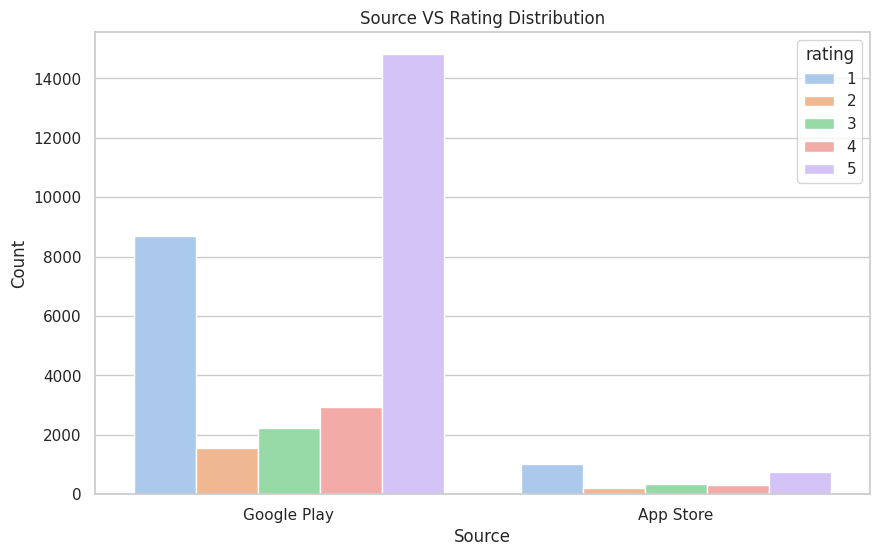

In [19]:
plt.figure(figsize=(10,6))

sns.countplot(x="source",hue='rating', data=df, palette='pastel')
plt.xlabel("Source")
plt.ylabel("Count")
plt.title("Source VS Rating Distribution")
plt.show()

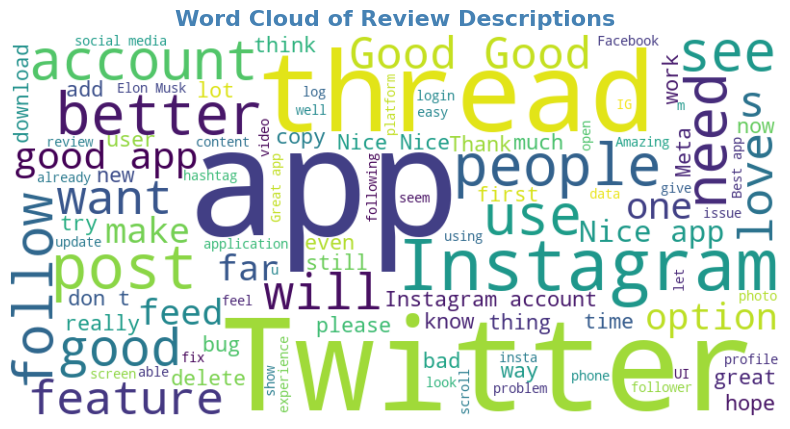

In [20]:
text = ' '.join(df['desc'])

custom_color_map = plt.cm.viridis

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=custom_color_map,
                      max_words=100, contour_width=3, contour_color='steelblue').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Review Descriptions', fontsize=16, fontweight='bold', color='steelblue')
plt.show()

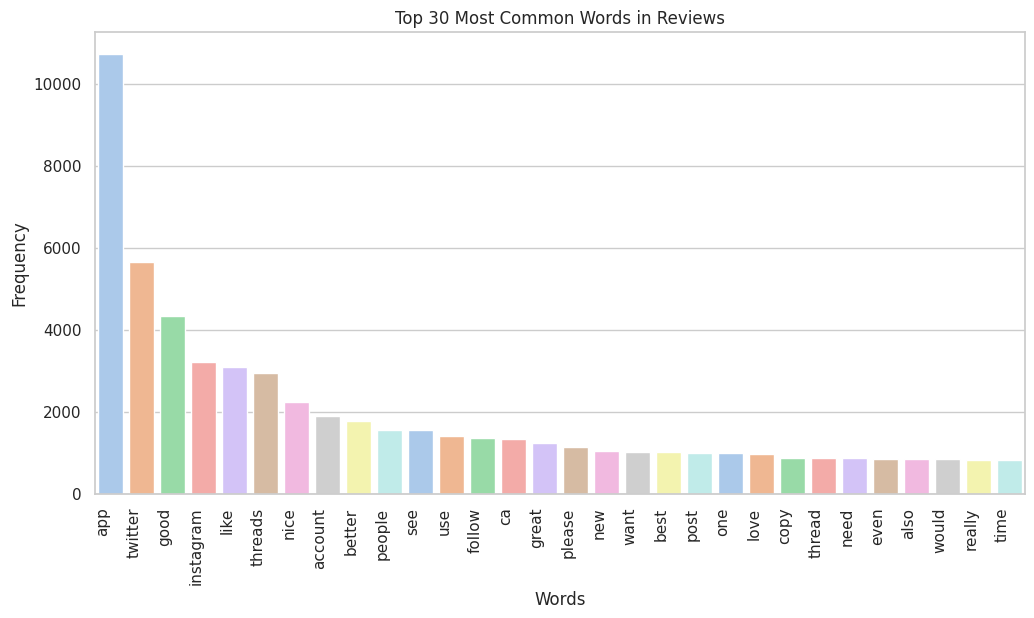

In [21]:
def process(text):
    words = word_tokenize(text.lower())      # Lower case
    stop_words = set(stopwords.words('english'))   # stopwords in text
    words = [word for word in words if word.isalpha() and word not in stop_words]   # condition alphabet only and no stop words
    return words

reviews = ' '.join(df["desc"])    # join data combine all reviews 

data = process(reviews)
words = Counter(data)

plt.figure(figsize=(12, 6))
sns.barplot(x=[word for word, count in words.most_common(30)], y=[count for word, count in words.most_common(30)],palette='pastel')
plt.title('Top 30 Most Common Words in Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90, ha='right')
plt.show()


In [22]:
X = df["desc"]
y= df["rating"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [23]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [24]:
vect = TfidfVectorizer()
X_train_tfidf = vect.fit_transform(X_train, y_train)
X_test_tfidf = vect.transform(X_test)

In [25]:
def predict(model,model_name):
    model.fit(X_train_tfidf,y_train)
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = model.predict_proba(X_test_tfidf)
    
    roc_auc = roc_auc_score(y_test,y_pred_proba, multi_class='ovr')
    acc = accuracy_score(y_test,y_pred)
    pre = precision_score(y_test,y_pred, average='weighted')
    f1 = f1_score(y_test,y_pred, average='weighted')
    print()
    print(model_name)
    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {pre:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print()
    
    plt.figure(figsize=(9, 6))

    colors = sns.color_palette('Set1', n_colors=5)
    for i in range(5):  # Assuming there are 5 classes (ratings 1 to 5)
        fpr, tpr, _ = roc_curve(y_test == (i + 1), y_pred_proba[:, i])
        roc_auc_curve = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, color=colors[i], label=f'Rating {i+1}, AUC = {roc_auc_curve:.2f}')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='dotted', alpha=0.7)
    plt.gca().set_facecolor('#f9f9f9')
    plt.tick_params(axis='x', colors='#666666')
    plt.tick_params(axis='y', colors='#666666')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.grid(color='#999999', linestyle='dotted')

    plt.show()


Logistic Regression
Accuracy: 0.70
Precision: 0.64
F1 Score: 0.65



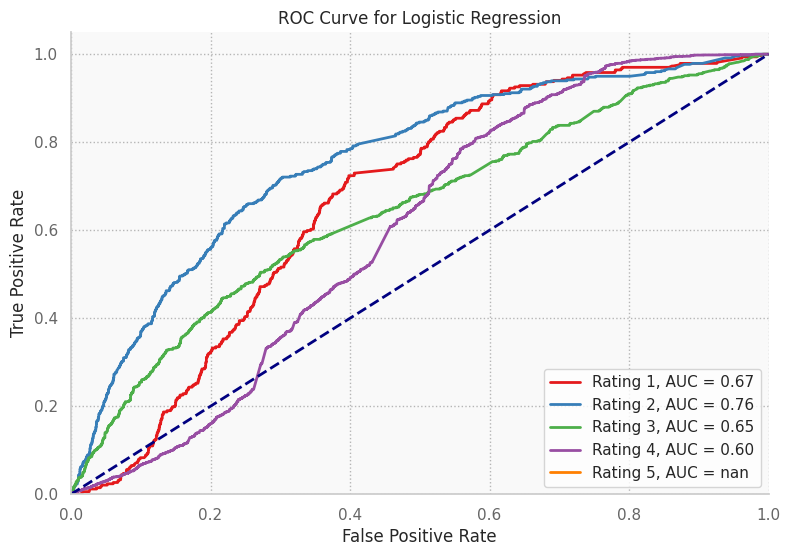

In [26]:
log_reg = LogisticRegression()
predict(log_reg, 'Logistic Regression')


DecisionTreeClassifier
Accuracy: 0.61
Precision: 0.58
F1 Score: 0.60



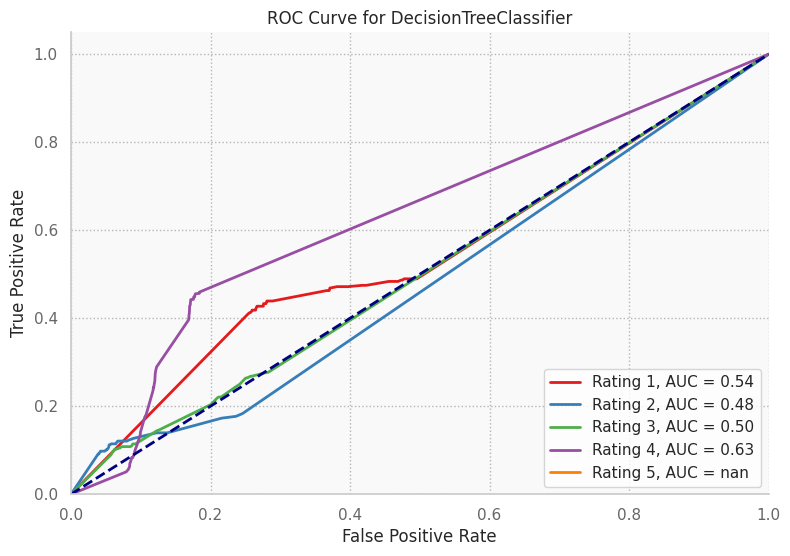

In [27]:
dt = DecisionTreeClassifier()
predict(dt,"DecisionTreeClassifier")


RandomForestClassifier
Accuracy: 0.68
Precision: 0.59
F1 Score: 0.61



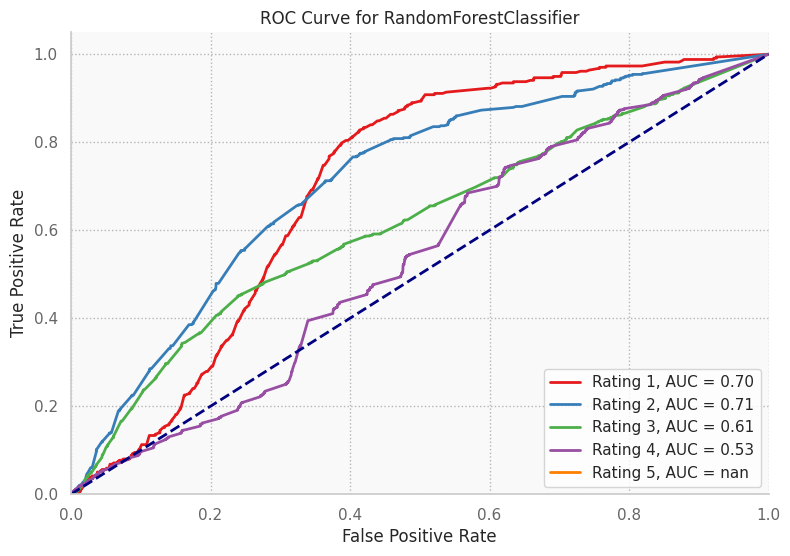

In [28]:
clf = RandomForestClassifier()
predict(clf,"RandomForestClassifier")


KNeighborsClassifier
Accuracy: 0.56
Precision: 0.50
F1 Score: 0.48



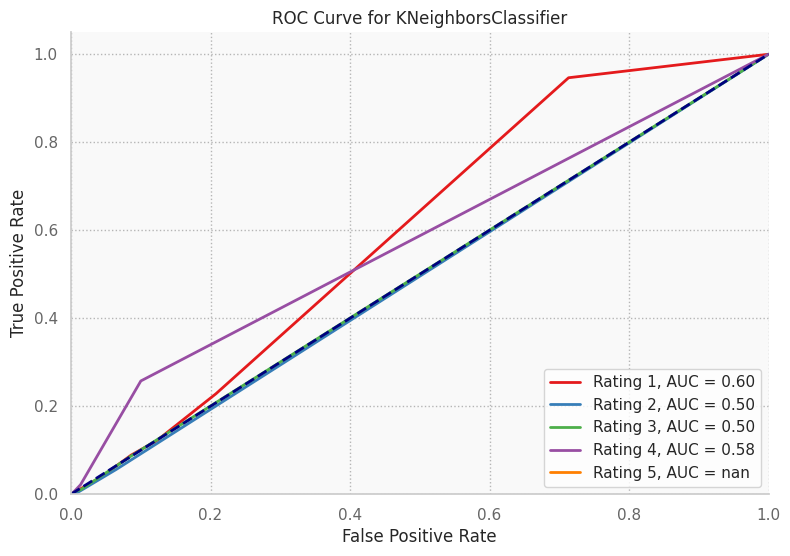

In [29]:
knn = KNeighborsClassifier()
predict(knn, "KNeighborsClassifier")


MultinomialNB
Accuracy: 0.68
Precision: 0.55
F1 Score: 0.60



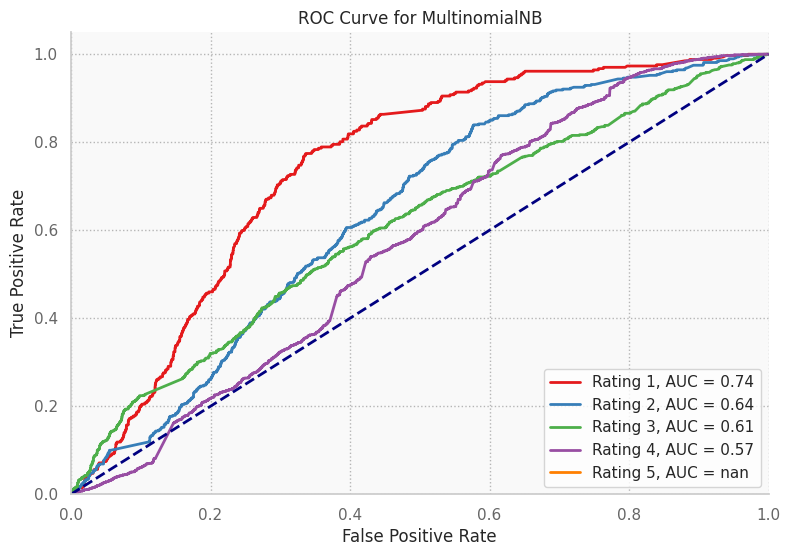

In [30]:
mnb = MultinomialNB()
predict(mnb, "MultinomialNB")


GradientBoostingClassifier
Accuracy: 0.65
Precision: 0.57
F1 Score: 0.59



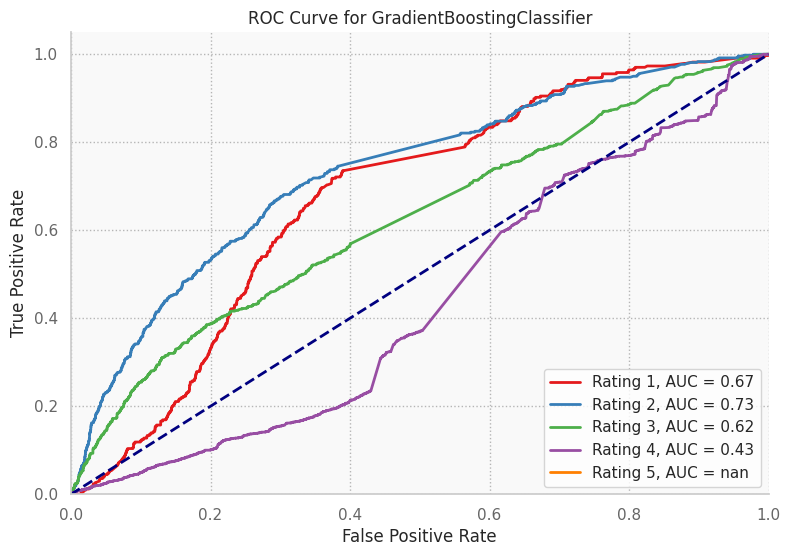

In [31]:
gbc = GradientBoostingClassifier()
predict(gbc,"GradientBoostingClassifier")